# Lecture 16 (5/2/2022)

**Announcements**



*Last time we covered:*
- Linear regression
    - Simple linear regression
    - Evaluating regression
    - Polynomial and multiple regression

**Today's agenda:**
- Multiple regression continued
- Overfitting


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Multiple Regression


## Big idea: multiple predictors for $y$

In real-world scenarios, it's common to explore the relationship between *multiple* predictor variables that all jointly impact the dependent variable. 

For this, we need **multiple regression**. 

Though the guiding principles are similar to *simple regression*, things can get much more complicated in multiple dimensions. Here, we'll provide enough of an overview for you to be able to use multiple regression as part of your modeling toolbox.

## Example: predicting life expectancy

Let's start with a familiar example.

In Problem Set 3 and elsewhere, we've looked at the *gapminder* dataset, which explores the relationship between GDP, population, and life expectancy at the national level and over time. 

Here, we'll just look at these variables for the most recent year (2007).

In [2]:
gap = pd.read_csv("https://raw.githubusercontent.com/UCSD-CSS-002/ucsd-css-002.github.io/master/datasets/gapminder.csv")

# Let's keep just some of the variables (note for pset!)
# NOTE: we're also just restricting ourselves to 2007
gap_subset = gap.loc[gap['year'] == 2007, ('country', 'year', 'lifeExp', 'pop', 'gdpPercap')].reset_index(drop = True)

# Add log transformed population and income
gap_subset['logPop'] = np.log10(gap_subset['pop'])
gap_subset['logGdpPercap'] = np.log10(gap_subset['gdpPercap'])
gap_subset

,country,year,lifeExp,pop,gdpPercap,logPop,logGdpPercap
0,Afghanistan,2007,43.828,31889923,974.580338,7.503653,2.988818
1,Albania,2007,76.423,3600523,5937.029526,6.556366,3.773569
2,Algeria,2007,72.301,33333216,6223.367465,7.522877,3.794025
3,Angola,2007,42.731,12420476,4797.231267,7.094138,3.680991
4,Argentina,2007,75.320,40301927,12779.379640,7.605326,4.106510
...,...,...,...,...,...,...,...
137,Vietnam,2007,74.249,85262356,2441.576404,7.930757,3.387670
138,West Bank and Gaza,2007,73.422,4018332,3025.349798,6.604046,3.480776
139,"Yemen, Rep.",2007,62.698,22211743,2280.769906,7.346583,3.358081
140,Zambia,2007,42.384,11746035,1271.211593,7.069891,3.104218


In Problem Set 3, you generated a graph that explored the relationship between income (GDP per-capita on $x$) and life expectancy (in years on $y$), alongside two additional predictors: region (color) and population (size).

![gap](img/gapminder.png)

Here, we want to know formally what the relationship is between the three continuous variables (income, life expectancy, and population). In other words, **can we predict life expectancy using both income *and* population better than we could only using one of those variables?**

Let's start by just examining each of the predictors in isolation to see if this is a plausible hypothesis.

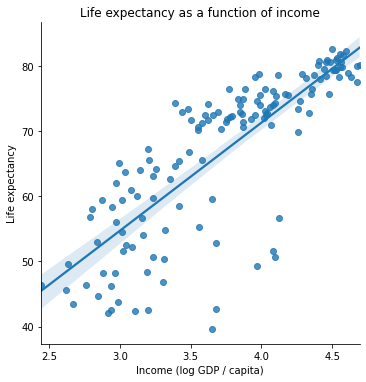

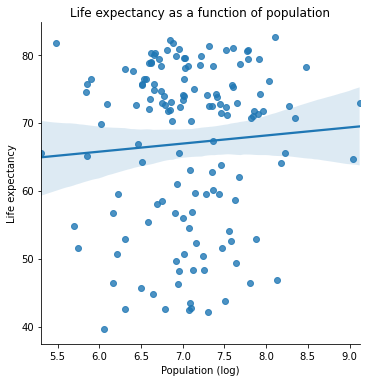

In [3]:
g = sns.lmplot(data = gap_subset, 
                    x = "logGdpPercap", # x1 
                    y = "lifeExp"
                   )
plt.title("Life expectancy as a function of income")
plt.xlabel("Income (log GDP / capita)")
plt.ylabel("Life expectancy")
plt.show()

h = sns.lmplot(data = gap_subset, 
                    x = "logPop", # x2 
                    y = "lifeExp"
                   )
plt.title("Life expectancy as a function of population")
plt.xlabel("Population (log)")
plt.ylabel("Life expectancy")
plt.show()

One of these variables has a strong positive relationship. The other one seems a bit less clear. 

How can we think about exploring the role that both of them play together in predicting life expectancy?

### Multiple regression: overview

Multiple regression is like linear regression except that we assume our dependent variable $y_i$ is *jointly* predicted by multiple independent variables: 

$x_1$, $x_2$, ..., $x_n$.

Simple linear regression generates a *predicted* $\hat{y}_i$ from $x_i$:

$\hat{y}_i = \beta_0 + \beta_1 x_i + \epsilon_i$

With multiple regression, we now extend this model to include multiple predictors for our data ($x_{1i}$, $x_{2i}$, ..., $x_{ni}$):

$\hat{y}_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \ ... \ + \beta_n x_{ni} + \epsilon_i $

In most cases, multiple regression once again uses the same *Ordinary Least Squares* (OLS) parameter estimation as simple regression. However, interpreting the parameter estimates is a little less straightforward.

*How would we interpret $\beta_0 = 1$, $\beta_1 = 2$, $\beta_2 = 3$?*

(Think of a simple example. What variables would you want to use to predict somebody's height *as accurately as possible*? Now imagine each of those variables is one of your $x_{ji}$ variables.)

## Multiple regression in python

The scikit-learn `LinearRegression` class is very easy to extend to multiple regression!

We'll also demonstrate the `statsmodels` approach below for more robust statistical analysis.

In [4]:
# scikit learn approach
from sklearn.linear_model import LinearRegression

x_vals = np.array(gap_subset[['logGdpPercap', 'logPop']]) # Note: this double bracket syntax is important!
x_vals = x_vals.reshape(len(gap_subset), 2)
x_vals

y_vals = np.array(gap_subset['lifeExp'])
y_vals

mod = LinearRegression().fit(X = x_vals, y = y_vals)

mod.intercept_
mod.coef_

array([16.6811828 ,  1.86827925])

What do the coefficient estimates above suggest? 

How should we interpret them? 

In [5]:
# R^2 for our regression
mod.score(X = x_vals, y = y_vals)

0.6649393884784984

In [6]:
# What if we don't include the population predictor?
x_single = np.array(gap_subset['logGdpPercap']) # Note: this double bracket syntax is important!
x_single = x_single.reshape(len(gap_subset), 1)
x_single

mod_simple = LinearRegression().fit(X = x_single, y = y_vals)
mod_simple.score(X = x_single, y = y_vals)

# Doesn't seem like population helps much...

0.6544490472926064

The statsmodels approach gives us a bit more insight here.

In [7]:
# statsmodels approach
import statsmodels.formula.api as smf

multiple_reg = smf.ols('lifeExp ~ logGdpPercap + logPop', data = gap_subset).fit()

# View the results
multiple_reg.summary()

# Our population variable does have a significant positive slope, 
# but it's pretty small and the effect may be driven by outliers.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeExp   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     137.9
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           9.91e-34
Time:                        18:22:54   Log-Likelihood:                -477.07
No. Observations:                 142   AIC:                             960.1
Df Residuals:                     139   BIC:                             969.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.6161      7.538     -1.143      0.255     -23.520       6.288
logGdpPercap    16.6812      1.008     16.555      0.000      14.689      18.673
logPop           1.8683      0.896      2.086      0.039       0.098       3.639
==============================================================================
Omnibus:                       34.155   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.987
Skew:                          -1.183   Prob(JB):                     1.15e-12
Kurtosis:                       4.923   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Regression: wrap-up

Regression is one of the most powerful tools in our data science / analysis toolkit. 

However, it's important to be familiar with the *limitations* in regression as well. 

One class of these limitations is when **the data violate the assumptions of linear regression**. We're *not* going to get into these issues in this class, but it's good to be aware that not all data (even data that looks linear!) can be accurately described by linear regression. There are a number of tricks for diagnosing this, such as plotting your residuals (we may explore this on the problem set as a way to cover some of this material).

However, an important limitation that we *will* discuss now is when **regression overfits the data**. Avoiding overfitting is something that arises in just about any modeling context. It's easiest to illustrate with regression, but the things we discuss here will be relevant throughout the remainder of the quarter.

***

# Overfitting


## What is it?

The basic principle behind overfitting is that when your modeling approach is sufficiently *unconstrained*, you can fit patterns in your data that *do not generalize*. 

What does it mean for a model to be unconstrained? What does it mean for the model not to generalize?

...


*How does this happen?* 

There are lots of ways this can arise (and what it looks like differs across modeling techniques).

Let's look at a canonical example just to get an intuition. For models that we learn about throughout the rest of the quarter, it's a useful exercise to think about what overfitting might look like.

## Example

Let's return to our `gapminder` dataset and the task of predicting *life expectancy* ($y$) based on *income* ($x$).

What kind of relationship do we think these variables have in the data below?

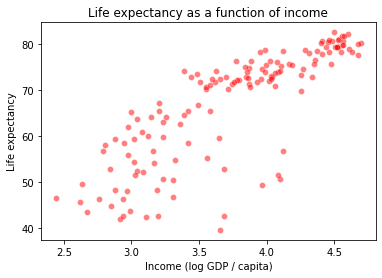

In [8]:
gap_subset


g = sns.scatterplot(data = gap_subset, 
                    x = "logGdpPercap", # x1 
                    y = "lifeExp",
                    color = "r",
                    alpha = 0.5
                   )
plt.title("Life expectancy as a function of income")
plt.xlabel("Income (log GDP / capita)")
plt.ylabel("Life expectancy")
plt.show()

Let's start with a **simple linear regression**:

In [9]:
# Estimate the model
x_vals = np.array(gap_subset['logGdpPercap']).reshape(len(gap_subset), 1)
y_vals = np.array(gap_subset['lifeExp'])
deg1_fits = LinearRegression().fit(X = x_vals, y = y_vals)

# Add predictions for this model to our dataframe
preds = gap_subset.loc[:, ("logGdpPercap", "lifeExp")].reset_index(drop = True)
preds['deg1_pred'] = deg1_fits.predict(X = x_vals)

preds

,logGdpPercap,lifeExp,deg1_pred
0,2.988818,43.828,54.519342
1,3.773569,76.423,67.534497
2,3.794025,72.301,67.873765
3,3.680991,42.731,65.999076
4,4.106510,75.320,73.056337
...,...,...,...
137,3.387670,74.249,61.134339
138,3.480776,73.422,62.678496
139,3.358081,62.698,60.643606
140,3.104218,42.384,56.433262


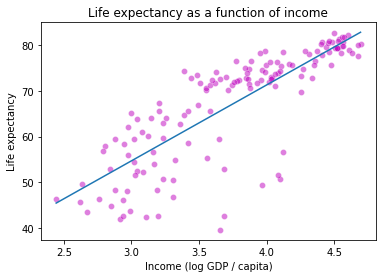

In [10]:
# Plot the fit

sns.scatterplot(data = preds, 
                x = "logGdpPercap",
                y = "lifeExp",
                color = "m",
                alpha = 0.5
               )
sns.lineplot(data = preds,
             x = "logGdpPercap",
             y = "deg1_pred"
            )


plt.title("Life expectancy as a function of income")
plt.xlabel("Income (log GDP / capita)")
plt.ylabel("Life expectancy")
plt.show()

How did we do? Maybe this data is *quadratic* or *cubic*?

In [11]:
from sklearn.preprocessing import PolynomialFeatures

# Fit degree 2 polynomial regression
poly2 = PolynomialFeatures(degree = 2, include_bias = False)
x2_features = poly2.fit_transform(x_vals)
mod2 = LinearRegression().fit(x2_features, y_vals)

# Fit degree 3 polynomial regression
poly3 = PolynomialFeatures(degree = 3, include_bias = False)
x3_features = poly3.fit_transform(x_vals)
mod3 = LinearRegression().fit(x3_features, y_vals)

# Add these to our predictions
preds['deg2_pred'] = mod2.predict(X = x2_features)
preds['deg3_pred'] = mod3.predict(X = x3_features)
preds

# How do these predictions look at first glance? More accurate?

,logGdpPercap,lifeExp,deg1_pred,deg2_pred,deg3_pred
0,2.988818,43.828,54.519342,54.128139,54.071604
1,3.773569,76.423,67.534497,68.392417,68.422855
2,3.794025,72.301,67.873765,68.722745,68.758756
3,3.680991,42.731,65.999076,66.871091,66.875117
4,4.106510,75.320,73.056337,73.506613,73.595809
...,...,...,...,...,...
137,3.387670,74.249,61.134339,61.765814,61.694179
138,3.480776,73.422,62.678496,63.433290,63.381871
139,3.358081,62.698,60.643606,61.226743,61.149956
140,3.104218,42.384,56.433262,56.420367,56.336913


Let's plot these lines and see how they look:

<AxesSubplot:xlabel='logGdpPercap', ylabel='lifeExp'>

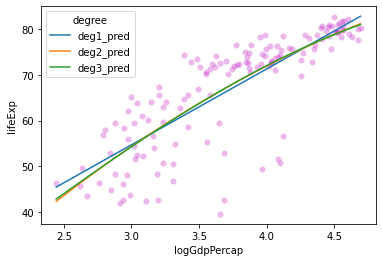

In [12]:
# First, let's make our data tidy for easier plotting
preds_long = preds.melt(
    id_vars = ["logGdpPercap", "lifeExp"],
    var_name = "degree",
    value_name = "prediction"
)

preds_long

# Now, let's take a look
sns.scatterplot(data = preds_long, 
                x = "logGdpPercap",
                y = "lifeExp",
                color = "m",
                alpha = 0.1
               )

sns.lineplot(
    data = preds_long,
    x = "logGdpPercap",
    y = "prediction",
    hue = "degree"
)

These lines look pretty similar. Do we see any change in $R^2$ values for these models?

In [13]:
# Get R^2 for each model
mod1_rsq = deg1_fits.score(X = x_vals, y = y_vals)
mod2_rsq = mod2.score(X = x2_features, y = y_vals)
mod3_rsq = mod3.score(X = x3_features, y = y_vals)

print("Degree 1 R^2: {} \nDegree 2 R^2: {} \nDegree 3 R^2: {}".format(
    mod1_rsq, mod2_rsq, mod3_rsq
))

Degree 1 R^2: 0.6544490472926064 
Degree 2 R^2: 0.6588616234359694 
Degree 3 R^2: 0.6589091468875565


*What does this tell us?*

...


*What happens if we try to fit a much higher-order polynomial function to this data?* Similar line or something else?


...




In [14]:
# Fit degree 10 polynomial regression
poly10 = PolynomialFeatures(degree = 10, include_bias = False)
x10_features = poly10.fit_transform(x_vals)
mod10 = LinearRegression().fit(x10_features, y_vals)

Let's compare this one to our $R^2$ values above:


In [15]:
# Calculate R^2 for our degree 10 polynomial
mod10_rsq = mod10.score(X = x10_features, y = y_vals)
mod10_rsq

0.6708222009621823

Improvement! Let's keep going! 

In [16]:
# Fit degree 25 polynomial regression
poly25 = PolynomialFeatures(degree = 25, include_bias = False)
x25_features = poly25.fit_transform(x_vals)
mod25 = LinearRegression().fit(x25_features, y_vals)

# Check R^2
mod25_rsq = mod25.score(X = x25_features, y = y_vals)
mod25_rsq

0.6716693321510845

Okay maybe things are slowing down... 

Let's plot our functions and see how they look.

<AxesSubplot:xlabel='logGdpPercap', ylabel='lifeExp'>

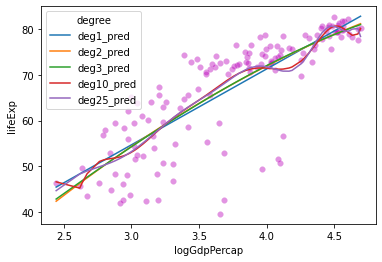

In [17]:
# Add to predictions dataframe and re-format
preds['deg10_pred'] = mod10.predict(X = x10_features)
preds['deg25_pred'] = mod25.predict(X = x25_features)

preds_long = preds.melt(
    id_vars = ["logGdpPercap", "lifeExp"],
    var_name = "degree",
    value_name = "prediction"
)

preds_long

# Now, let's take a look
sns.scatterplot(data = preds_long, 
                x = "logGdpPercap",
                y = "lifeExp",
                color = "m",
                alpha = 0.1
               )

sns.lineplot(
    data = preds_long,
    x = "logGdpPercap",
    y = "prediction",
    hue = "degree"
)

Hmmm....

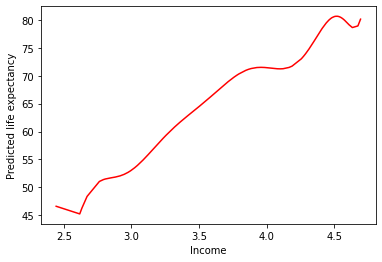

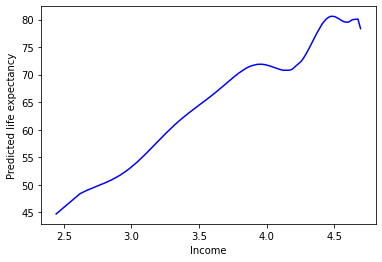

In [18]:
sns.lineplot(
    data = preds,
    x = "logGdpPercap",
    y = "deg10_pred",
    color = "r"
)
plt.xlabel("Income")
plt.ylabel("Predicted life expectancy")
plt.show()

sns.lineplot(
    data = preds,
    x = "logGdpPercap",
    y = "deg25_pred",
    color = "b"
)
plt.xlabel("Income")
plt.ylabel("Predicted life expectancy")
plt.show()

This doesn't seem like it's capturing the underlying process that generated our data...

![spaghetti](img/spaghetti.jpeg)

Aside: overfitting is easiest to demonstrate with polynomial regression because it makes Least Squares Spaghetti. However, this problem can arise in almost any modeling context. Think about what this might look like with *multiple regression*.

## Overfitting summary

The high-degree polynomials above are **unconstrained**, leading them to fit our data *too* well.

This creates worries that they won't **generalize**. 

*But how do we test this?*


***

# Cross-validation: avoiding overfitting


There are many different techniques for *cross-validation*, one of which we discussed on Friday. 

However, at their heart, all of them involve the same underlying principle: *estimate your model parameters with only a subset (or repeated subsets) of your data, then evaluate your model on the remaining data to ensure generalizability*. 

This technique allows you to ensure that your model is a good fit, or do *model comparison* to choose among different candidate models (such as our polynomial models above).

Rather than go through all of the different ways of doing this, I'll walk through a few of the more well known ones. This will give you a feel for how cross-validation works. 

1. ***Holdout* cross-validation**: this is the technique we reviewed on Friday
    - Split data into *training* and *test* data (e.g. 75-25 split)
    - Train model on *training data only*
    - Evaluate model on *test data*
2. ***k-fold* cross-validation**: This is a more robust version of holdout cross-validation
    - Split data into *k* equal sized buckets (randomly!)
    - Choose one of the buckets to be *test* data and assign the rest to be *training* data
    - Perform holdout cross-validation with this data
    - Then, repeat the above *for each of the other buckets* and average your test results (e.g., MSE) over the multiple runs
3. ***Monte-carlo* cross-validation** (repeated random subsampling): Similar to k-fold, but *random*
    - Split the data into training and test data randomly
    - Evaluate model on test data
    - Repeat this process many times
4. **Exhaustive cross-validation** (various methods): The most common of these are *leave-one-out* or *leave-p-out* cross-validation
    - For every individual value in the data or set of $p$ values, train the model on all remaining data then evalute the model using this individual or set of $p$ values
    - Note: this is *exhaustive* because every data point or set of $p$ data points is used in the test set, but is often computationally intractable!
5. **Other** methods: specific to particular types of data (e.g., time series data, classification data)


For more info on this, you can check out [this](https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d) blog, or the wikipedia [page](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) devoted to this topic, or many others like it online!

# Cross-Validation Summary

The techniques above are used with many if not all of the modeling techniques we'll discuss this quarter. 

From here on out, you should **assume that some form of cross-validation is a *required* component of any model fitting process**, much like looking at your data, cleaning it, and other core aspects of analysis.